# Summary:
This notebook will use **Doc2Vec** to train an embedding matrix in which each document is represented by a numeric vector with a fixed dimension containing its semantic meaning. The obtained matrix can be concatenated with the transformed matrix containing information about `Gene` and `Variation`. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** will then be applied to the matrix either only containing text information or both text and gene variation data.

# Table of contents
<br >&nbsp;&nbsp;&nbsp;[2.7 Doc2Vec](#Part2.7_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.1 Train Doc2Vec model](#Part2.7.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2 Train machine learning models using Doc2Vec + Gene Variation](#Part2.7.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2.1 LogisticRegression](#Part2.7.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2.2 RandomForestClassifier](#Part2.7.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2.3 XGBClassifier](#Part2.7.2.3_link)

In [87]:
import pandas as pd
import numpy as np
import os

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from tsne import bh_sne
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import itertools

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE

In [45]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [6]:
bow_clean=list(train_df.text_clean)+list(test_df.text_clean)

In [7]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”",
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants']
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
stop_words = set(list(stop_word1)+stop_word2+custom_words)   ## 433
print(len(stop_words))

433


<a id='Part2.7_link'></a>
## 2.7 Doc2Vec

https://radimrehurek.com/gensim/models/doc2vec.html
<br>In additon to using Word2Vec to represent each word with a numeric vector embeded with semantic meaning of the word, we can train Doc2Vec model to represent each document with a numeric vector.

<a id='Part2.7.1_link'></a>
### 2.7.1 Train Doc2Vec model

In [52]:
def constructLabeledSentences(data):
    '''
    Credits go to https://www.kaggle.com/alyosama/doc2vec-with-keras-0-77
    '''
    sentences=[]
    for index, row in enumerate(data):
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [53]:
sentences = constructLabeledSentences(bow_clean)

In [54]:
sentences[0]

LabeledSentence(words=['Cyclin', 'dependent', 'kinases', 'CDKs', 'regulate', 'a', 'variety', 'of', 'fundamental', 'cellular', 'processes', 'CDK10', 'stands', 'out', 'as', 'one', 'of', 'the', 'last', 'orphan', 'CDKs', 'for', 'which', 'no', 'activating', 'cyclin', 'has', 'been', 'identified', 'and', 'no', 'kinase', 'activity', 'revealed', 'Previous', 'work', 'has', 'shown', 'that', 'CDK10', 'silencing', 'increases', 'ETS2', 'v', 'ets', 'erythroblastosis', 'virus', 'E26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'of', 'the', 'MAPK', 'pathway', 'which', 'confers', 'tamoxifen', 'resistance', 'to', 'breast', 'cancer', 'cells', 'The', 'precise', 'mechanisms', 'by', 'which', 'CDK10', 'modulates', 'ETS2', 'activity', 'and', 'more', 'generally', 'the', 'functions', 'of', 'CDK10', 'remain', 'elusive', 'Here', 'we', 'demonstrate', 'that', 'CDK10', 'is', 'a', 'cyclin', 'dependent', 'kinase', 'by', 'identifying', 'cyclin', 'M', 'as', 'an', 'activating', 'cyclin', 'Cyclin', 'M', 'an', 'orp

Here I use `vector_size=100` and each document is represented by a numeric vector with 100 dimensions. Negative sampling is used in model training and 5 noise words will be drawn. 

In [23]:
doc2vec = gensim.models.Doc2Vec(vector_size=100, window=5, min_count=1, negative=5, workers=4, iter=5,seed=1)
doc2vec.build_vocab(sentences)
doc2vec.train(sentences, total_examples=doc2vec.corpus_count, epochs=doc2vec.iter)

location=os.path.join(base_dir, 'preprocessing/personalized_medicine_d2vmodel_dim100.d2v')
doc2vec.save(location)

In [ ]:
#location=os.path.join(base_dir, 'preprocessing/personalized_medicine_d2vmodel_dim100.d2v')
#location=os.path.join(base_dir, 'preprocessing/personalized_medicine_d2vmodel.d2v')
#doc2vec=gensim.models.Doc2Vec.load(location)

In [28]:
#location=os.path.join(base_dir, 'preprocessing/personalized_medicine_d2vmodel_dim300.d2v')
location=os.path.join(base_dir, 'preprocessing/personalized_medicine_d2vmodel_dim100.d2v')
doc2vec = gensim.models.Doc2Vec.load(location)
print('Total number of documents: {}'.format(doc2vec.corpus_count))

Total number of documents: 8983


Before moving forward to converting texts to vector representations, we can first look at the important attributes of the trained doc2vec model.

In [29]:
## get embedding dimension of doc2vec (dimensionality of the feature vectors)
dim=len(doc2vec.wv.syn0[0])
print('The dimension of the feature vector for doc2vec is {}'.format(len(doc2vec.wv.syn0[0])))

The dimension of the feature vector for doc2vec is 100


In [30]:
## get size of the vocabulary
print('Vocabulary size: {}'.format(len(doc2vec.wv.index2word)))
print('Sample words in the vocabulary: {}'.format(doc2vec.wv.index2word[:10]))
print('embedding matrix shape: {}'.format(doc2vec.wv.vectors.shape))

Vocabulary size: 194354
Sample words in the vocabulary: ['the', 'of', 'and', 'in', 'to', 'with', 'a', 'that', 'were', 'for']
embedding matrix shape: (194354, 100)


In [31]:
## get vector representation for word 'cyclin'
print(len(doc2vec.wv['cyclin']))
print("Vector representation for 'cyclin': {}".format(doc2vec.wv['cyclin']))

100
Vector representation for 'cyclin': [ 3.0227797e+00  3.0006616e+00  1.7094846e+00 -1.9524845e-01
  1.2227225e+00  1.0706599e+00  2.0547329e-01  8.4609008e-01
  7.6356784e-02  1.8972318e+00 -1.1334466e+00 -1.6948812e+00
 -3.1574008e+00 -1.4221401e+00 -1.4540118e+00 -8.5080922e-01
 -5.8072743e+00 -1.9378264e-01  1.5706763e+00 -2.2825634e+00
 -2.1530926e-01 -1.2293128e+00  3.1429842e+00  1.6716315e-01
 -2.4255532e-01 -3.9429796e+00 -3.1976813e-01 -7.7311751e-03
  3.4082046e+00 -9.5814747e-01 -1.5514631e+00 -3.1163520e-01
 -1.7869267e+00 -6.9900697e-01  2.6676712e+00 -1.0532617e-01
 -2.1828601e+00  3.4320924e-01  2.0731478e+00  6.4349264e-01
  1.4434596e+00  5.1992702e-01 -2.2930031e-01  1.9481391e+00
  1.6960849e-01 -2.1519945e+00  1.3303578e+00 -1.1313457e+00
 -2.5416539e+00 -1.5299594e-01 -2.9122005e+00  1.4070193e+00
 -1.9444927e+00 -5.3907406e-01  2.2089069e-01  2.5766079e+00
  7.2509199e-01  1.5219814e-01  1.9913036e+00  1.6701294e+00
  1.9459679e+00 -4.4744220e-03  5.3444475e-01

In [32]:
## get 'most_similar' words
result,scores = zip(*doc2vec.most_similar(positive=['benign','passenger'], negative=['malignant','aggressive'],topn=20))
print(result)

('A1225G', 'neutral', 'harmless', 'overabundance', 'igv', 'non', 'SF3B1H662Q', 'misattributed', 'passengers', 'controls', 'werecompletely', 'conservatively', '2308', 'BIKAROS', 'multiallelic', 'RAB26', 'morn', 'aTruncating', 'o60', 'noncoding')


Here I try to get words with semantic meaning similar to `benign` and `passenger`, opposite to `malignant` and `aggressive`. The output words include `neutral`, `harmless`, which have the same meaning as `benign` in description of cancer. Words like `controls` also hold similar semantic meanings.

In [62]:
## get 'most_similar' words
result,scores = zip(*doc2vec.most_similar(positive=['malignant','aggressive'], negative=['benign','passenger'],topn=20))
print(result)

('advanced', 'ULTRA', 'indolent', 'genegenerally', 'aggressiveclinical', 'receptorlung', 'T2aN0Mx', 'immunogenic', 'elegant', 'instructing', 'erythroblastic', 'ccgctactatgccatgatgatcctcaagaaggagg', 'PACC', 'unpigmented', 'plasmidsThe', 'LXSH', 'transplantations', 'Choroid', 'Serandour', 'tantalizingly')


Conversely, words like `advanced` have similar semantic meanings to `malignant`, but opposite to `benign`.

In [57]:
index_list=[]
result1,scores = zip(*doc2vec.most_similar(positive=['benign','passenger'], negative=['malignant','aggressive'],topn=50))
result2,scores = zip(*doc2vec.most_similar(positive=['malignant','aggressive'], negative=['benign','passenger'],topn=50))
word_list=list(result1)+list(result2)
for word in word_list:
    index_list.append(doc2vec.wv.index2word.index(word))
tsne = TSNE()
embed_tsne = tsne.fit_transform(doc2vec.wv.vectors[index_list, :])
embed_df=pd.DataFrame({'word':np.array(word_list),'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1],'color':np.append(np.repeat('benign',len(embed_tsne)//2),np.repeat('malignant',len(embed_tsne)//2))})

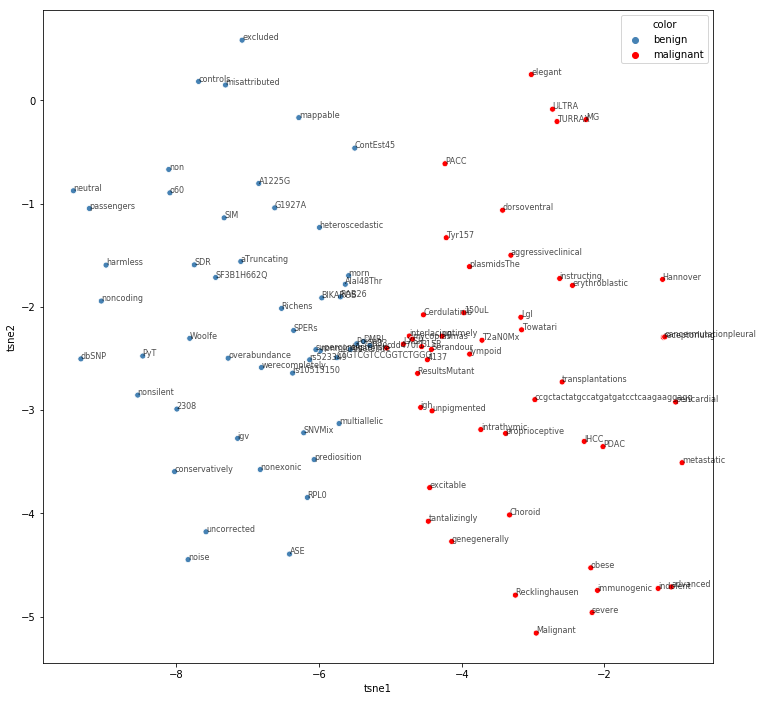

In [58]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df,hue='color',palette=['steelblue','red'],ax=ax)
for idx in range(len(index_list)):
    ax.annotate(word_list[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,size=8)

In [55]:
## get vector representation for document
result2=doc2vec.docvecs['Text_1']
print(len(result2))
print(result2)

100
[ 0.5315664   0.01659387  0.12430497  0.5904903  -0.4013869   0.6125294
  0.3044386   0.6212301   0.5890885  -2.6682239  -0.7116507   0.95983446
 -0.06704067  0.74945694 -0.37833875 -1.1244192   1.2471316   0.03199426
 -0.26857013 -0.5940404   1.1372229  -0.88890916  0.63909423  0.04676766
  0.4588172   0.45796618  0.7793742  -0.5602934   0.23360828  0.14313109
  1.1245127  -0.00574392  0.27756745 -0.3910006  -0.18425924 -0.24083665
 -1.2952416   0.480814   -0.5133705   1.3429749  -2.1586843  -0.15471809
 -0.16002753 -1.8465538   1.1961343  -0.05940428  0.8428295   0.22094822
  0.8670309  -0.79531384  0.4804355  -0.1879034  -1.6279994   0.6210506
  1.2798661   1.222966   -1.8632021  -0.66001564 -2.071933    1.3807672
 -0.7223441  -1.3901695  -0.12710549 -0.8511946   0.62990105 -1.0313672
  0.29999164 -1.460872   -1.0813099  -2.1845698   0.3054807  -1.2861655
 -0.10650261  0.44049314  0.83488923  1.0585432  -0.94484484  0.790669
 -1.0920093   0.08300614 -0.359708    0.9672089  -0.58

In [59]:
## Extract vector representations for each document in numpy array
train_arrays=np.zeros((len(train_df), dim))
test_arrays=np.zeros((len(test_df), dim))
for i in range(len(train_df)):
    train_arrays[i]=doc2vec.docvecs['Text_'+str(i)]
j=0
for i in range(len(train_df), len(train_df)+len(test_df)):
    test_arrays[j]=doc2vec.docvecs['Text_'+str(i)]
print('train_arrays.shape: {}'.format(train_arrays.shape))
print('test_arrays.shape: {}'.format(test_arrays.shape))
## doc2vec.docvecs.vectors_docs

train_arrays.shape: (3316, 100)
test_arrays.shape: (5667, 100)


In [60]:
## Convert a random document to an encoded vector using the trained doc2vec model
sent='cyclin d1 can be upregulated in cacners'
result3=doc2vec.infer_vector(sent.split(), alpha=0.001, min_alpha=0.001, steps=10000)
print(len(result3))
result3

100


array([ 3.409004  ,  0.5162262 , -1.939773  , -2.0537999 ,  0.11466511,
        1.6265976 ,  1.8512032 , -0.07608002, -0.19908322, -1.2123407 ,
        0.14459121,  1.102081  ,  1.4970583 ,  2.4779491 ,  0.57928413,
       -0.4580188 ,  0.5654624 , -1.6823413 , -0.909618  , -2.4081116 ,
       -0.55900717,  1.7352372 , -2.9998095 ,  0.05776739, -0.5492544 ,
       -0.981107  , -0.3874312 , -0.11382923,  0.4154759 , -0.5324287 ,
       -0.7014506 , -2.3557208 ,  1.8704323 , -1.2982348 , -2.2153797 ,
       -0.83441013,  0.6843288 ,  0.47355542, -0.96043223,  1.435134  ,
       -0.33852273, -0.14827971, -1.370465  , -2.0378628 ,  3.562001  ,
       -1.65942   , -1.5736401 ,  0.89792216,  0.5001286 ,  0.27976748,
       -3.1209936 ,  0.9146207 , -0.8570312 ,  0.9595762 , -0.3076361 ,
       -1.7485455 , -3.242484  , -1.5733289 , -0.4005575 ,  2.0884874 ,
       -0.6155833 , -0.01854756,  1.4072508 ,  0.6678335 , -0.5821141 ,
       -1.5211552 ,  1.4017736 , -0.15038937,  1.052588  , -0.31

We can visualize the spatial distribution of numeric representations of each document in t-SNE plot.

In [63]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(train_arrays)
embed_df=pd.DataFrame({'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1],'class':train_df.Class.values})

In [64]:
embed_df.head()

,tsne1,tsne2,class
0,-16.844845,-11.928549,1
1,-0.494302,-9.215835,2
2,-0.492885,-9.214485,2
3,-0.580812,-20.208437,3
4,61.824451,18.477201,4


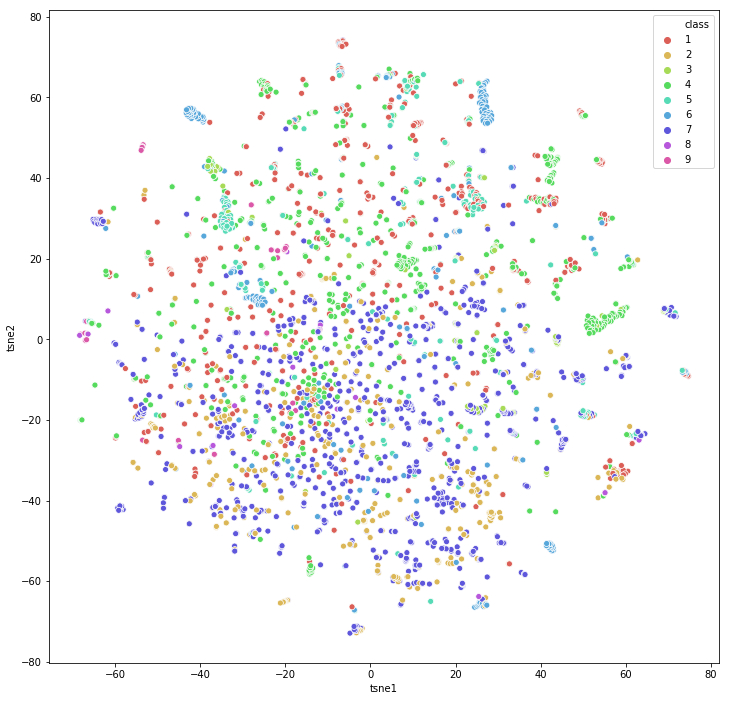

In [70]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df,hue='class',hue_order=list(np.arange(1,10)),palette=sns.color_palette('hls',9),ax=ax)

We cannot observe distinct clusters using t-SNE plot, which suggests that machine learning models are needed to further classify each document.

<br>Before moving foward, I will concatenate the information from transformed `Gene and Variation` data as described in `LSA` and `Word2Vec` analysis.

#### Convert Gene and Variation

In [72]:
data_df=train_df.append(test_df, ignore_index=True, sort=False)
one_hot_gene=pd.get_dummies(data_df.Gene)
one_hot_variation=pd.get_dummies(data_df.Variation)
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
one_hot_gene_truncated=svd.fit_transform(one_hot_gene.values)
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
one_hot_variation_truncated=svd.fit_transform(one_hot_variation.values)
train_set=np.concatenate((one_hot_gene_truncated[:len(train_df)],one_hot_variation_truncated[:len(train_df)],train_arrays), axis=1)
print('train_set.shape: {}'.format(train_set.shape))

train_set.shape: (3316, 150)


<a id='Part2.7.2_link'></a>
### 2.7.2 Train machine learning models using Doc2Vec + Gene Variation

Here are some functions used in model evaluation.

In [73]:
def plot_val_curve(train_scores,test_scores,param_name, param_vals,title,logx=True):
    train_mean = train_scores.mean(axis=1)
    print('{}: {}'.format(param_name, param_vals))
    print('train_mean: {}'.format(train_mean))
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    print('test_mean: {}'.format(test_mean))
    print('-'*80)
    print('{}: {} achieves highest test score: {}'.format(param_name,param_vals[np.argmax(test_mean)], test_mean.max()))
    print('-'*80)
    test_std = test_scores.std(axis=1)
    fig,ax=plt.subplots(1,1,figsize = (12,5))
    plt.title(title,fontsize=18)
    if logx:
        plt.semilogx(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.semilogx(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    else:
        plt.plot(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    plt.fill_between(param_vals, train_mean-train_std, train_mean+train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_vals, test_mean-train_std, test_mean+test_std, alpha = 0.15, color = 'b')
    plt.legend(loc = 'lower right')
    plt.xlabel('{}'.format(param_name),fontsize=12)
    plt.ylabel('Score',fontsize=12)
    plt.ylim([-0.05,1.05])
    ax.vlines(param_vals[np.argmax(test_mean)], -0.05, 1.05, linestyles='-.', color = sns.xkcd_rgb["pale red"])
    plt.show()

In [74]:
def model_eval(clf, X, y):
    cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
    probas = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    preds=np.unique(y)[pred_indices]
    accuracy = accuracy_score(y, preds)
    logloss = log_loss(y, probas)
    print('accuracy score: {}'.format(accuracy))
    print('log_loss: {}'.format(logloss))
    output = pd.DataFrame(probas,columns=['Class{}'.format(i) for i in range(1,10)])
    output['pred']=preds
    return output

In [75]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [77]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [78]:
def plot_ROC_curve(acc_df):
    probas=np.array(acc_df.drop(['pred'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (y == i+1).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

<a id='Part2.7.2.1_link'></a>
### 2.7.2.1 LogisticRegression

* Model: StandardScaler + LogisticRegression

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.31838354 0.35963128 0.43215793 0.4908128  0.55089616 0.59054908
 0.63088346 0.6577983  0.67619567 0.68283013 0.68923895 0.69421596]
test_mean: [0.30126762 0.32327463 0.37601338 0.42761005 0.45756551 0.47113858
 0.44399602 0.41802479 0.39421184 0.3818649  0.37402571 0.36920403]
--------------------------------------------------------------------------------
C: 0.001873817422860383 achieves highest test score: 0.4711385784855443
--------------------------------------------------------------------------------


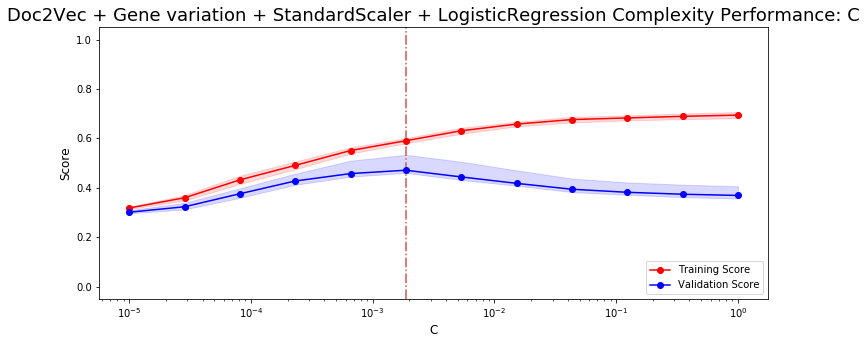

In [82]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='Doc2Vec + Gene variation + StandardScaler + LogisticRegression Complexity Performance: C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

In [83]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
lr=LogisticRegression(n_jobs=-1,random_state=8)
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"C":[0.001,0.002,0.005,0.01]}
clf=GridSearchCV(lr, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.002, 0.005, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [84]:
print("C: {}".format(clf.best_estimator_.get_params()['C']))
# pd.DataFrame.from_dict(clf.cv_results_)

C: 0.002


In [85]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
lr=LogisticRegression(n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.4662243667068758
log_loss: 1.5900115615567647


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.0s remaining:   28.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


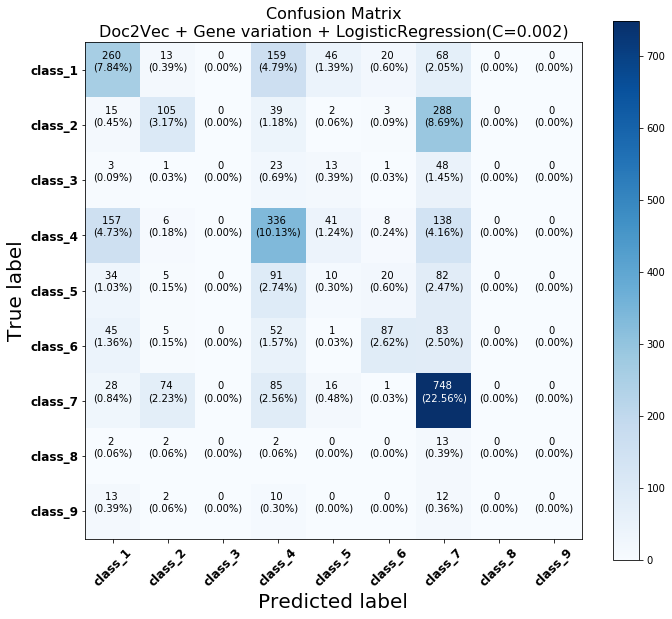

In [88]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nDoc2Vec + Gene variation + LogisticRegression(C=0.002)', cmap=plt.cm.Blues)

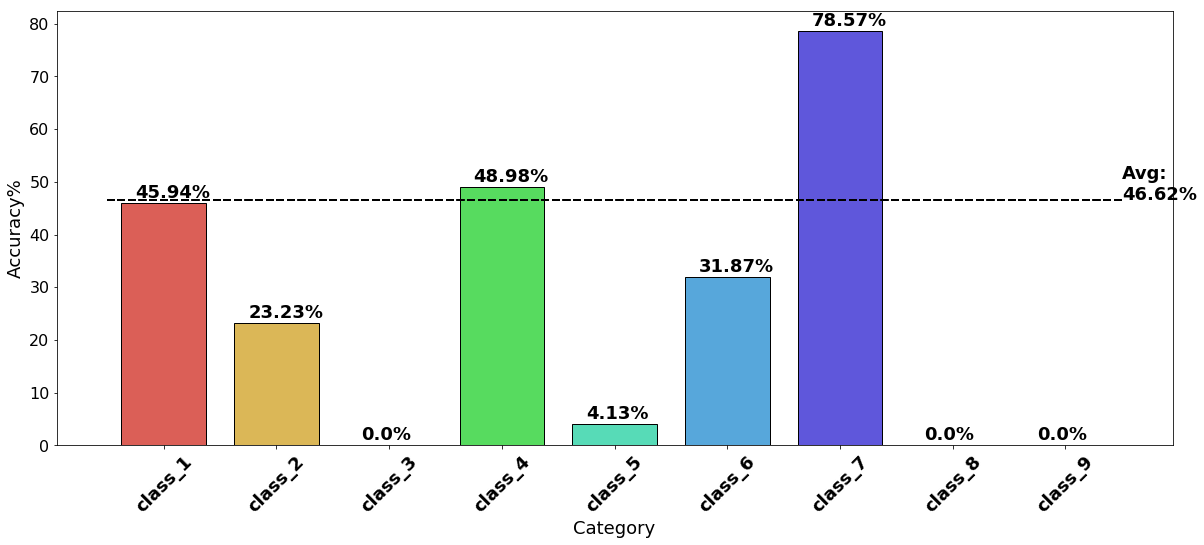

In [89]:
plot_acc_bar(cm,46.62)

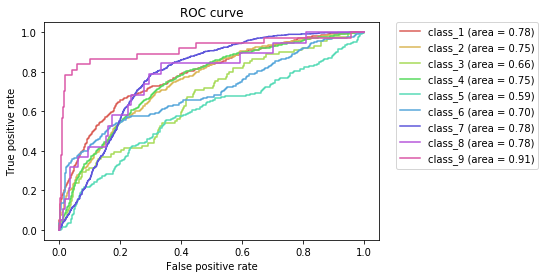

In [90]:
plot_ROC_curve(output)

<a id='Part2.7.2.2_link'></a>
### 2.7.2.2 RandomForestClassifier

* Model: RandomForestClassifier

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.3213315  0.47826959 0.57268993 0.87117513 0.9923858  0.99215915
 0.99215915 0.99215915]
test_mean: [0.31699689 0.39512765 0.4171552  0.40717462 0.36688366 0.36834509
 0.36834509 0.36834509]
--------------------------------------------------------------------------------
max_depth: 5 achieves highest test score: 0.4171551950682518
--------------------------------------------------------------------------------


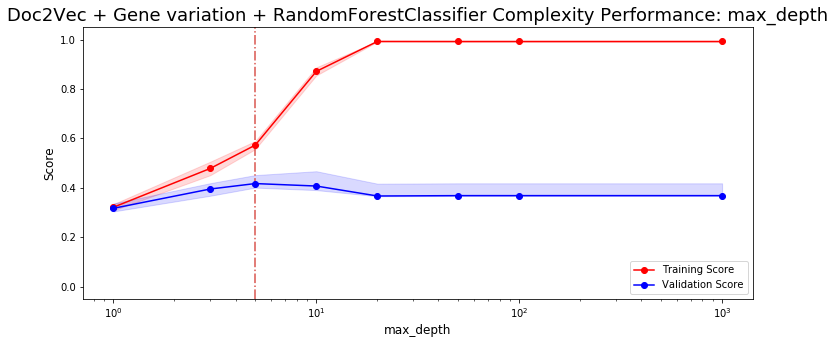

In [91]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='Doc2Vec + Gene variation + RandomForestClassifier Complexity Performance: max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.99215915 0.86218384 0.69836008 0.47114071 0.39573628 0.36444397]
test_mean: [0.36834509 0.41236794 0.41832787 0.37882054 0.36581729 0.33685749]
--------------------------------------------------------------------------------
min_samples_leaf: 15 achieves highest test score: 0.41832787099139185
--------------------------------------------------------------------------------


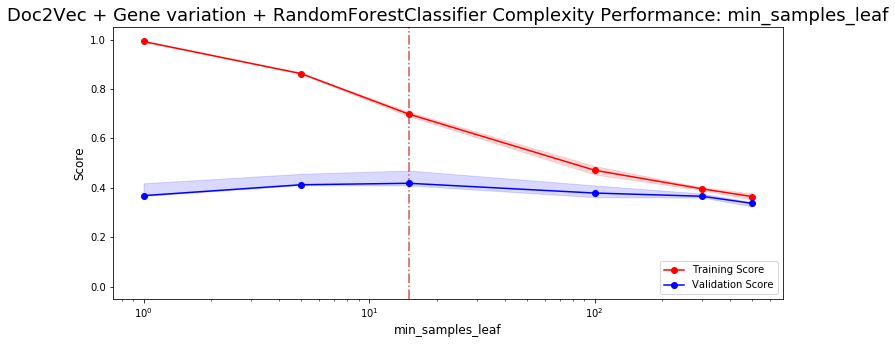

In [92]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='Doc2Vec + Gene variation + RandomForestClassifier Complexity Performance: min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

In [93]:
X=train_set
y=train_df.Class.values
clf = RandomForestClassifier(max_depth=5,min_samples_leaf=15,n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.4077201447527141
log_loss: 1.671249335530217


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


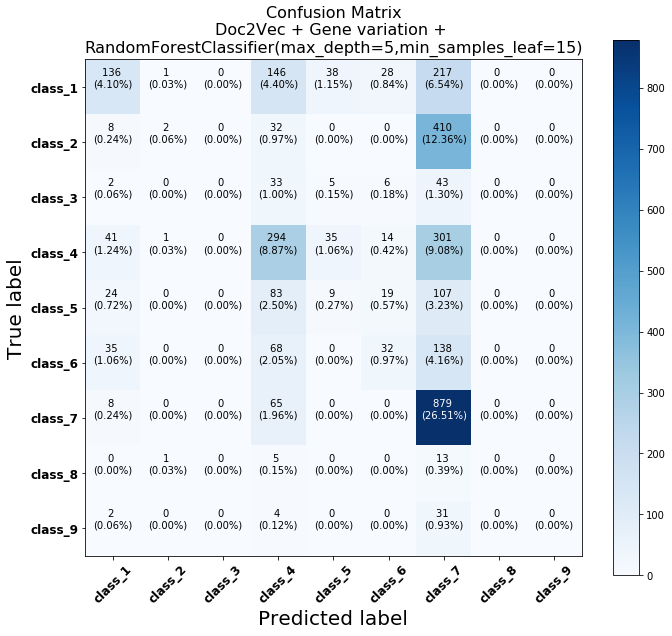

In [94]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nDoc2Vec + Gene variation + \nRandomForestClassifier(max_depth=5,min_samples_leaf=15)', cmap=plt.cm.Blues)

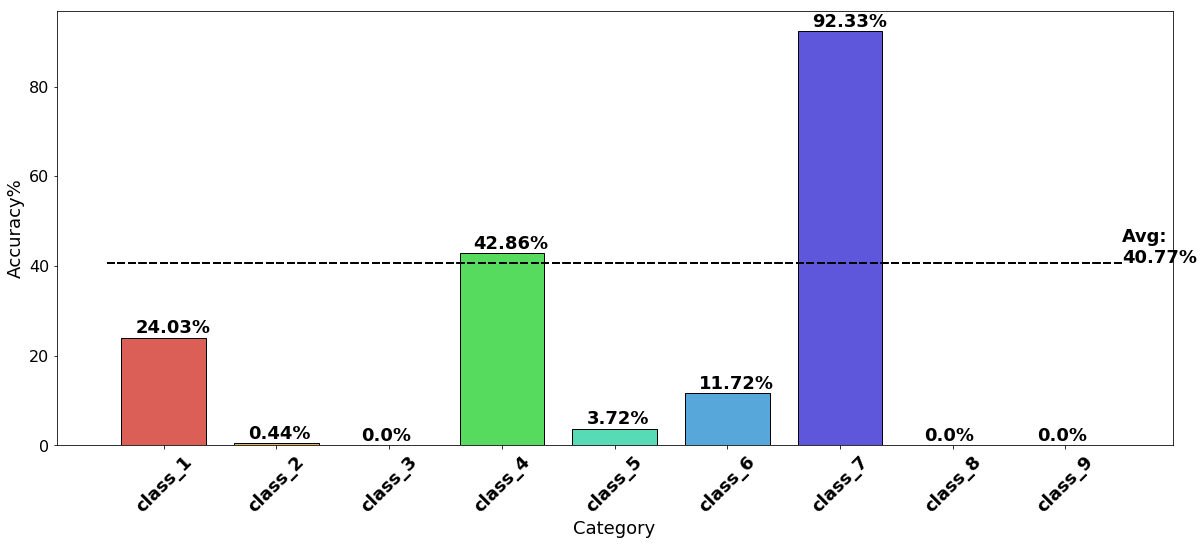

In [95]:
plot_acc_bar(cm,40.77)

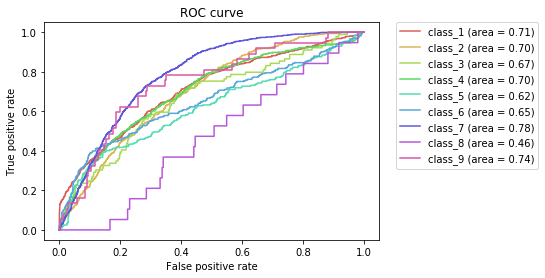

In [96]:
plot_ROC_curve(output)

<a id='Part2.7.2.3_link'></a>
### 2.7.2.3 XGBClassifier

* Model: XGBClassifier

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.8551725  0.86143478 0.87002653 0.87341873 0.87726167]
test_mean: [0.42511083 0.41388889 0.4078863  0.4136046  0.41000016]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.42511083107345166
--------------------------------------------------------------------------------


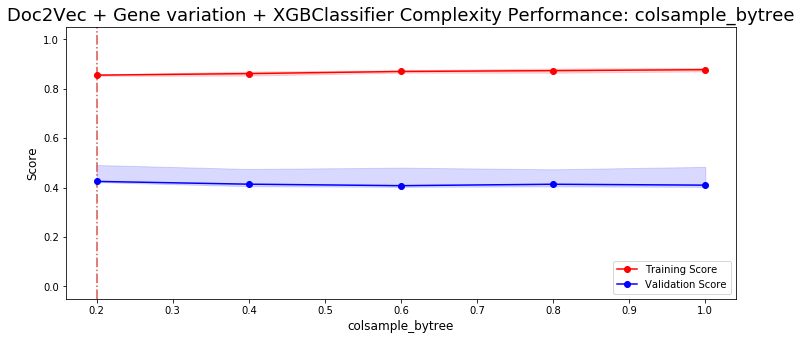

In [97]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')
title='Doc2Vec + Gene variation + XGBClassifier Complexity Performance: colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.87726167 0.87077909 0.86331691 0.85472012 0.84808438 0.82486426]
test_mean: [0.41000016 0.41153201 0.40790062 0.41363687 0.40488305 0.40164457]
--------------------------------------------------------------------------------
min_child_weight: 8 achieves highest test score: 0.41363687285970796
--------------------------------------------------------------------------------


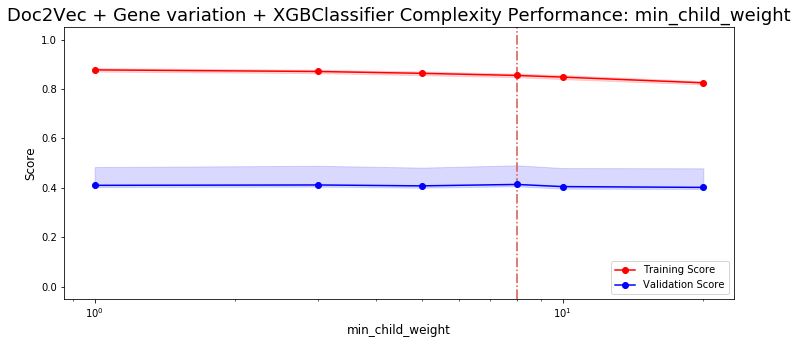

In [98]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')
title='Doc2Vec + Gene variation + XGBClassifier Complexity Performance: min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=True)

In [99]:
X=train_set
y=train_df.Class.values
clf = XGBClassifier(colsample_bytree=0.2,min_child_weight=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.42310012062726177
log_loss: 1.632602999886145


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.2s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


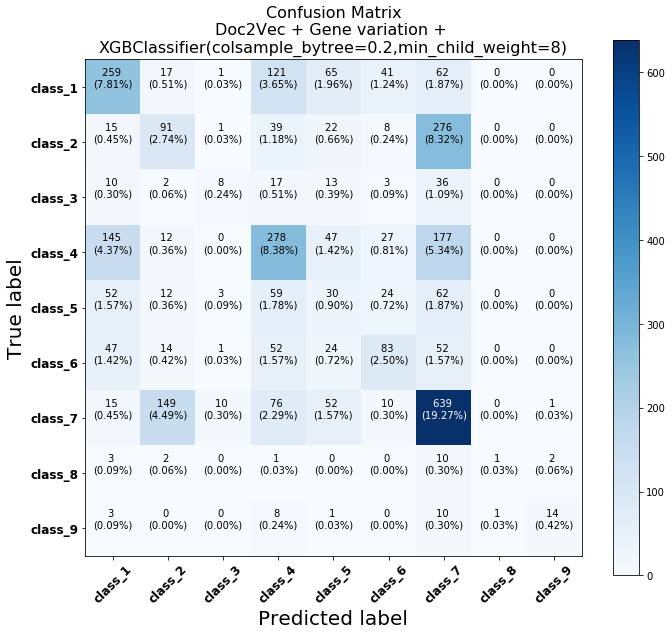

In [100]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nDoc2Vec + Gene variation + \nXGBClassifier(colsample_bytree=0.2,min_child_weight=8)', cmap=plt.cm.Blues)

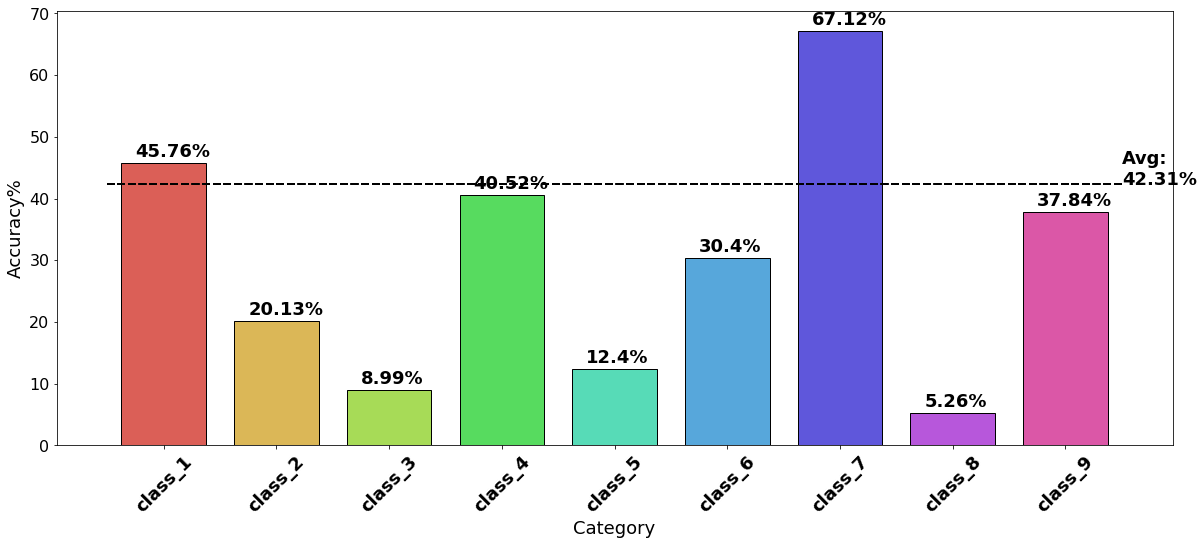

In [101]:
plot_acc_bar(cm,42.31)

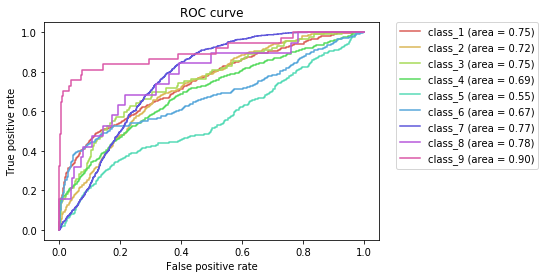

In [102]:
plot_ROC_curve(output)

## Conclusion for Doc2Vec

1. Doc2Vec model with gene variation information does not perform better than Word2vec model, with overall validation accuracy around 0.47 for **LogisticRegression(C=0.002)**.
2. Overall training performance for **RandomForestClassifier** and **XGBClassifier** models is not good.